In [1]:
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr
import itertools
from scipy.special import erfc
import galois
# from Dec import Dec

In [2]:
import math
import numpy as np

class Decoder:
    
    def __init__ (self,H, channel_model, channel_parameters, num_iter,cluster_size):
        # code parameters
        self.n = H.shape[1]
        self.k = self.n - H.shape[0]
        self.H = H
        self.model = channel_model
        self.params = channel_parameters
        self.num_iter = num_iter
        
        # misc parameters (epsilon : for numerical stability)
        self.ep = 1e-5
        
        # graph parameters
        self.num_VN = self.n
        self.num_CN = self.n-self.k
        self.cluster_size = cluster_size
        
        # adjacency list for VN and CN
        self.CN = []
        self.VN = []
        self.construct_graph(H)
        self.initialize_clusters(self.cluster_size)
        self.iteration_number = 0
        self.policy = None # policy for choosing clusters (using RL)
        
    # build the adjacency list for Tanner Graph
    def construct_graph(self,H):
        for i in range(self.num_CN):
            temp = []
            for j in range(self.num_VN):
                if H[i,j]==1:
                    temp.append(j)
            self.CN.append(temp)
            
        for i in range(self.num_VN):
            temp = []
            for j in range(self.num_CN):
                if H[j,i]==1:
                    temp.append(j)
            self.VN.append(temp)
    
    # print the tanner graph
    def print_graph(self,mode):
        if mode=="matrix":
            print(self.H)
        elif mode=="list":
            print('CN : ',self.CN)
            print('VN : ',self.VN)
        else:
            print('Invalid mode')
    
    
    # initialize clusters of CNs
    def initialize_clusters(self,cluster_size):
        self.num_clusters = math.ceil(self.num_CN/cluster_size)
        self.MI = np.zeros(self.num_clusters) # for storing current MI of clusters

        self.clusters = []
        for i in np.arange(0,self.num_CN,cluster_size):
            temp = []
            for j in range(i,min(i+cluster_size,self.num_CN)):
                temp.append(j)
            self.clusters.append(temp)  
            

                    
    # returns the absolute min, 2nd min and parity of the input array
    def get_min(self,arr):
        arr = np.array(arr)
        arr = arr[~np.isnan(arr)]
        parity = np.prod(np.sign(arr))
        if len(arr) < 2:
            print("arr = ",arr)
            raise ValueError("Not enough valid elements in the array.")
        arr = np.sort(np.abs(arr))
        return arr[0],arr[1],parity
    
    # perform row update of cluster a 
    def row_update(self,a):
        # subtract step (removing known beliefs)
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = self.sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(self.L[i])
            for j in range(self.num_VN):
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = p*np.sign(self.L[i,j])*m2 if np.abs(self.L[i,j])==m1 else p*np.sign(self.L[i,j])*m1

    def col_update(self,a):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] + tot
            
    def pseudo_row_update(self,a):
        # subtract step (removing known beliefs)
        p_L = self.L
        p_sum = self.sum
        
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p_sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(p_L[i])
            for j in range(self.num_VN):
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p*np.sign(p_L[i,j])*m2 if np.abs(p_L[i,j])==m1 else p*np.sign(p_L[i,j])*m1
        
        return p_L, p_sum

    def pseudo_col_update(self, a, p_L, p_sum):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] + tot
        
        return p_L


    def decode(self,y,verbose="off",scheduling="round-robin"):
        # sum is initialized by incoming beliefs (initial LLRs)
        self.sum = y
        
        # initializing the storage matrix
        self.L = np.full(self.H.shape, np.nan, dtype=float)  # Initialize with NaNs
        for i in range(self.num_CN):
            for j in range(self.num_VN):
                self.L[i,j] = 0 if self.H[i,j]==1 else np.nan
        
        # initial MI approximation
        self.MI = self.get_MI(self.L)
        
        for k in range(self.num_iter):
            self.iteration_number = k
            a = self.get_next_cluster(k,scheduling)
            if verbose=="on":
                print("Iteration : ",k,"\tCluster scheduled : ",a)
            self.row_update(a)
            self.col_update(a)
            c_hat = np.array([1 if val<0 else 0 for val in self.sum])
            if self.stopping_criteria(k,c_hat):
                break
        return c_hat
    
    def get_MI(self,L):
        var = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            total = 0
            count = 0
            for i in self.clusters[a]:
                for j in self.CN[i]:
                    total = total + np.abs(L[i,j])
                    count = count + 1
            mean = total/count
            var[a] = mean*2
        
        MI = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            MI[a] = self.J(var[a])
        
        return MI

        
    def J(self,sigma):
        # constants
        a_J1 = -0.0421061
        b_J1 = 0.209252
        c_J1 = -0.00640081

        a_J2 = 0.00181491
        b_J2 = -0.142675
        c_J2 = -0.0822054
        d_J2 = 0.0549608

        # threshold sigma*
        sigma_star = 1.6363
        
        if 0 <= sigma <= sigma_star:
            return a_J1 * sigma**3 + b_J1 * sigma**2 + c_J1 * sigma
        elif sigma_star < sigma < 10:
            exponent = a_J2 * sigma**3 + b_J2 * sigma**2 + c_J2 * sigma + d_J2
            return 1 - math.exp(exponent)
        else:  # sigma >= 10
            return 1

            
        
    def stopping_criteria(self,k,c_hat):
        c1 = k>self.num_iter
        c2 = (np.sum(np.dot(self.H,c_hat.T)%2)==0)
        return c1 or c2
    
    # calculates the difference between information metrics for cluster a
    def calculate_residual(self, info, info_new, a):
        return info_new[a] - info[a]
    
    def get_next_cluster(self,iter_number,scheduling):
        # round robin
        if scheduling=="round-robin":
            return (iter_number%self.num_clusters)
        
        elif scheduling=="residual-llr":
            llr_gains = np.zeros(self.num_clusters)
            for a in range(self.num_clusters):
                p_L, p_sum = self.pseudo_row_update(a)
                max_diff = -100000
                for j in self.CN[a]:
                    max_diff = max(np.abs(self.L[a,j]-p_L[a,j]),max_diff)
                llr_gains[a] = max_diff
            return np.argmax(llr_gains)
                
    
        # Information Gain
        MI_gains = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            p_L, p_sum = self.pseudo_row_update(a)
            p_L = self.pseudo_col_update(a,p_L,p_sum)
            MI_new = self.get_MI(p_L)
            gain = self.calculate_residual(self.MI, MI_new, a)
            MI_gains[a] = gain
            
        a = np.argmax(MI_gains)
        return a
        
    
        

In [3]:
def circular_shift_identity(z, k):
    if k == -1:
        return np.zeros((z, z), dtype=int)
    else:
        return np.roll(np.eye(z, dtype=int), -k, axis=1)

def expand_base_matrix(B, z):
    m, n = B.shape
    H = np.zeros((m * z, n * z), dtype=int)  # Full parity check matrix initialized to zeros

    for i in range(m):
        for j in range(n):
            # Expand each base matrix element into a z x z block
            block = circular_shift_identity(z, B[i, j])
            H[i * z:(i + 1) * z, j * z:(j + 1) * z] = block

    return H
# generates list of codewords corresponding to the parity check matrix H
def get_codewords(H):
    GF = galois.GF(2)
    A = GF(H)
    N = A.null_space()
    vec = [np.array(v) for v in itertools.product([0, 1], repeat=N.shape[0])]
    C = np.array(GF(vec) @ N)
    return C

In [4]:
# B = np.loadtxt('./base_matrices/NR_1_6_13.txt', dtype=int)
# print("Shape of B : ",B.shape)

# H = expand_base_matrix(B=B,z=13)
# print("Shape of H : ",H.shape)
H = np.array( [[0,0,1,1,0,0,1,0,0,0,0,0,0,0,0]
,[1,0,0,0,1,0,0,1,0,0,0,0,0,0,0]
,[0,1,0,0,0,1,0,0,1,0,0,0,0,0,0]
,[1,0,0,0,0,1,1,0,0,0,0,0,0,0,0]
,[0,1,0,1,0,0,0,1,0,0,0,0,0,0,0]
,[0,0,1,0,1,0,0,0,1,0,0,0,0,0,0]
,[1,0,0,1,0,0,0,0,1,0,0,0,0,0,0]
,[0,1,0,0,1,0,1,0,0,0,0,0,0,0,0]
,[0,0,1,0,0,1,0,1,0,0,0,0,0,0,0]
,[1,0,0,1,0,0,1,0,0,1,0,0,1,0,0]
,[0,1,0,0,1,0,0,1,0,0,1,0,0,1,0]
,[0,0,1,0,0,1,0,0,1,0,0,1,0,0,1]],dtype=int)

In [5]:
n = H.shape[1]
C = get_codewords(H)
print("H : \n",H)


print("\nCodewords :")
C = np.array(C)
print(C)

dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)


H : 
 [[0 0 1 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 1 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 1 0 0 1 0]
 [0 0 1 0 0 1 0 0 1 0 0 1 0 0 1]]

Codewords :
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 0 0 1 0 0 1]
 [0 0 0 1 1 1 1 1 1 0 1 0 0 1 0]
 [0 0 0 1 1 1 1 1 1 0 1 1 0 1 1]
 [0 0 0 1 1 1 1 1 1 1 0 0 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 0 1 1 0 1]
 [0 0 0 1 1 1 1 1 1 1 1 0 1 1 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 0 0 0 1 1 1 0 0

# BER vs SNR plot

In [36]:
def getBER_round_robin(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,3)
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(-1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="round-robin")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N
    

In [37]:
def getBER_flooding(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,H.shape[0])
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="round-robin")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N
    

In [6]:
def getBER_MI(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,3)
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="mi")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N


In [39]:
def getBER_llr_residual(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,1)
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="residual-llr")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N


### Getting BER plot for LLR-residual based scheduler

In [40]:
print("BERs for llr-residual\n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_llr_residual = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_llr_residual(snr,H,C,100,N)
    bers_llr_residual.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for llr-residual
-----------------

BER = 0.40174666666669373			 SNR(db) = 0.1
BER = 0.3980000000000276			 SNR(db) = 0.2
BER = 0.4012133333333625			 SNR(db) = 0.35
BER = 0.4013600000000266			 SNR(db) = 0.5
BER = 0.4030200000000263			 SNR(db) = 0.9
BER = 0.40396666666669223			 SNR(db) = 1.5
BER = 0.4059066666666893			 SNR(db) = 2.2
BER = 0.4072800000000209			 SNR(db) = 3
BER = 0.40675333333335356			 SNR(db) = 3.7
BER = 0.40596000000001803			 SNR(db) = 4.3
BER = 0.4113133333333488			 SNR(db) = 4.9


In [41]:
print(bers_llr_residual)

[0.40174666666669373, 0.3980000000000276, 0.4012133333333625, 0.4013600000000266, 0.4030200000000263, 0.40396666666669223, 0.4059066666666893, 0.4072800000000209, 0.40675333333335356, 0.40596000000001803, 0.4113133333333488]


### Getting BER plot for Mutual-Information based scheduler

In [7]:
print("BERs for MI\n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_MI = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_MI(snr,H,C,100,N)
    bers_MI.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for MI
-----------------

BER = 0.046659999999998925			 SNR(db) = 0.1
BER = 0.04542666666666565			 SNR(db) = 0.2
BER = 0.04455999999999895			 SNR(db) = 0.35
BER = 0.04315333333333243			 SNR(db) = 0.5
BER = 0.039473333333332555			 SNR(db) = 0.9
BER = 0.03519999999999938			 SNR(db) = 1.5
BER = 0.030546666666666215			 SNR(db) = 2.2
BER = 0.024053333333333163			 SNR(db) = 3
BER = 0.019413333333333324			 SNR(db) = 3.7
BER = 0.016466666666666775			 SNR(db) = 4.3
BER = 0.015040000000000154			 SNR(db) = 4.9


In [8]:
print(bers_MI)

[0.046659999999998925, 0.04542666666666565, 0.04455999999999895, 0.04315333333333243, 0.039473333333332555, 0.03519999999999938, 0.030546666666666215, 0.024053333333333163, 0.019413333333333324, 0.016466666666666775, 0.015040000000000154]


### Getting BER plot for flooding

In [10]:
print("BERs for flooding\n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_flooding = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_flooding(snr,H,C,100,N)
    bers_flooding.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for flooding
-----------------

BER = 0.10186666666667456			 SNR(db) = 0.1
BER = 0.10068666666667382			 SNR(db) = 0.2
BER = 0.09892000000000717			 SNR(db) = 0.35
BER = 0.09746666666667378			 SNR(db) = 0.5
BER = 0.08983333333333929			 SNR(db) = 0.9
BER = 0.078806666666671			 SNR(db) = 1.5
BER = 0.07275333333333686			 SNR(db) = 2.2
BER = 0.06168666666666754			 SNR(db) = 3
BER = 0.052079999999998426			 SNR(db) = 3.7
BER = 0.04648666666666496			 SNR(db) = 4.3
BER = 0.04043333333333201			 SNR(db) = 4.9


### Getting BER plot for round-robin

In [11]:
print("BERs for round-robin\n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_round_robin = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_round_robin(snr,H,C,100,N)
    bers_round_robin.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for round-robin
-----------------

BER = 0.049566666666665586			 SNR(db) = 0.1
BER = 0.04962666666666552			 SNR(db) = 0.2
BER = 0.04781333333333225			 SNR(db) = 0.35
BER = 0.046799999999998974			 SNR(db) = 0.5
BER = 0.04079333333333247			 SNR(db) = 0.9
BER = 0.03711999999999932			 SNR(db) = 1.5
BER = 0.03193333333333291			 SNR(db) = 2.2
BER = 0.024706666666666495			 SNR(db) = 3
BER = 0.02105333333333328			 SNR(db) = 3.7
BER = 0.017973333333333362			 SNR(db) = 4.3
BER = 0.015120000000000135			 SNR(db) = 4.9


In [12]:
print("For RR : \n",bers_round_robin)
print("For Flooding : \n",bers_flooding)
print("For MI : \n",bers_MI)
print("For Residual LLR : \n",bers_llr_residual)



For RR : 
 [0.049566666666665586, 0.04962666666666552, 0.04781333333333225, 0.046799999999998974, 0.04079333333333247, 0.03711999999999932, 0.03193333333333291, 0.024706666666666495, 0.02105333333333328, 0.017973333333333362, 0.015120000000000135]
For Flooding : 
 [0.10186666666667456, 0.10068666666667382, 0.09892000000000717, 0.09746666666667378, 0.08983333333333929, 0.078806666666671, 0.07275333333333686, 0.06168666666666754, 0.052079999999998426, 0.04648666666666496, 0.04043333333333201]
For MI : 
 [0.04899999999999882, 0.04874666666666551, 0.04383999999999902, 0.04350666666666574, 0.0406533333333325, 0.035479999999999366, 0.031893333333332836, 0.023386666666666552, 0.020733333333333284, 0.01756666666666672, 0.01424000000000018]


## Plotting the BERs vs SNR (dB)

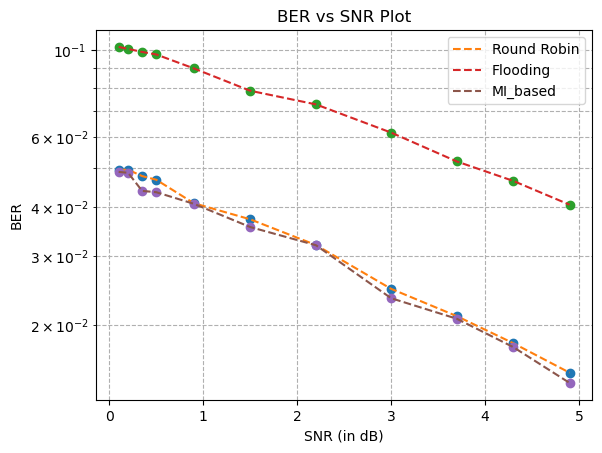

In [13]:
plt.plot(snrdb_vals, bers_round_robin, 'o')  
plt.plot(snrdb_vals, bers_round_robin, '--',label="Round Robin")
plt.plot(snrdb_vals, bers_flooding, 'o')  
plt.plot(snrdb_vals, bers_flooding, '--',label="Flooding")
plt.plot(snrdb_vals, bers_MI, 'o')  
plt.plot(snrdb_vals, bers_MI, '--',label="MI_based")


plt.title("BER vs SNR Plot")
plt.ylabel("BER")
plt.xlabel("SNR (in dB)")
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")



# BER vs SNR for a 30x50 matrix

In [42]:
def circular_shift_identity(z, k):
    """
    Generate a z x z identity matrix with circularly shifted rows by k positions.
    If k == -1, return a z x z zero matrix.
    """
    if k == -1:
        return np.zeros((z, z), dtype=int)
    else:
        return np.roll(np.eye(z, dtype=int), -k, axis=1)

def expand_base_matrix(B, z):
    """
    Expand the base matrix B into the full parity check matrix with expansion factor z.

    B: Base matrix of size m x n
    z: Expansion factor

    Returns the expanded parity-check matrix of size (m*z) x (n*z).
    """
    m, n = B.shape
    H = np.zeros((m * z, n * z), dtype=int)  # Full parity check matrix initialized to zeros

    for i in range(m):
        for j in range(n):
            # Expand each base matrix element into a z x z block
            block = circular_shift_identity(z, B[i, j])
            H[i * z:(i + 1) * z, j * z:(j + 1) * z] = block

    return H



In [43]:
# generates list of codewords corresponding to the parity check matrix H
def get_codewords(H):
    GF = galois.GF(2)
    A = GF(H)
    N = A.null_space()
    vec = [np.array(v) for v in itertools.product([0, 1], repeat=N.shape[0])]
    C = np.array(GF(vec) @ N)
    return C

In [44]:
B = np.array([[0,2,-1,3,-1,-1,2,4,1,0],
            [3,1,-1,-1,0,0,1,2,3,0],
            [1,0,0,-1,1,4,2,1,0,-1],
            [-1,0,0,2,3,-1,-1,-1,0,-1],
            [1,0,2,0,1,0,-1,-1,-1,-1],
            [2,1,0,0,2,-1,-1,-1,1,-1]]
            ,dtype=int)

# B = np.array([[-1,0,1],
#              [1,0,2]],dtype=int)
print("B = \n",B)
z = 5

H = expand_base_matrix(B,z)
np.savetxt('output.txt',H,fmt="%d")
print("H : \n",H)

C = get_codewords(H)
print("Codewords : \n",C)
print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)



B = 
 [[ 0  2 -1  3 -1 -1  2  4  1  0]
 [ 3  1 -1 -1  0  0  1  2  3  0]
 [ 1  0  0 -1  1  4  2  1  0 -1]
 [-1  0  0  2  3 -1 -1 -1  0 -1]
 [ 1  0  2  0  1  0 -1 -1 -1 -1]
 [ 2  1  0  0  2 -1 -1 -1  1 -1]]
H : 
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
Codewords : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
1048576  codewords found
dmin =  9


In [45]:
def getBER_round_robin_1(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,6)
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(-1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="round-robin")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N

def getBER_flooding(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,H.shape[0])
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="round-robin")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N

def getBER_MI_1(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,6)
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(-1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="mi")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N

def getBER_residual_llr_1(snr,H,C,num_iter,N):
    # this is for bsc, similarly do for others too
    avg = 0
    tg = Decoder(H,"bsc",0,num_iter,1)
    
    for i in range(N):
        c = C[np.random.choice(len(C))]
        sigma = 1/math.sqrt(snr)
        y = np.power(-1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = tg.decode(y,scheduling="residual-llr")
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        avg = avg + e
    
    return avg/N


In [46]:
print("BERs for residual-llr for 30x50 H \n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_residual_llr_1 = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_residual_llr_1(snr,H,C,100,N)
    bers_residual_llr_1.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for residual-llr for 30x50 H 
-----------------

BER = 0.3249100000000359			 SNR(db) = 0.1
BER = 0.3247600000000361			 SNR(db) = 0.2
BER = 0.32384400000003444			 SNR(db) = 0.35
BER = 0.32545600000003544			 SNR(db) = 0.5
BER = 0.3249440000000366			 SNR(db) = 0.9
BER = 0.325944000000035			 SNR(db) = 1.5
BER = 0.33004000000003547			 SNR(db) = 2.2
BER = 0.334646000000036			 SNR(db) = 3
BER = 0.33957400000003324			 SNR(db) = 3.7
BER = 0.34902000000003597			 SNR(db) = 4.3
BER = 0.3562520000000354			 SNR(db) = 4.9


In [47]:
print(bers_residual_llr_1)

[0.3249100000000359, 0.3247600000000361, 0.32384400000003444, 0.32545600000003544, 0.3249440000000366, 0.325944000000035, 0.33004000000003547, 0.334646000000036, 0.33957400000003324, 0.34902000000003597, 0.3562520000000354]


In [18]:
print("BERs for MI for 30x50 H \n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_MI_1 = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_MI_1(snr,H,C,100,N)
    bers_MI_1.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for MI for 30x50 H 
-----------------

BER = 0.11965600000000122			 SNR(db) = 0.1
BER = 0.11606200000000054			 SNR(db) = 0.2
BER = 0.11369800000000045			 SNR(db) = 0.35
BER = 0.10641400000000008			 SNR(db) = 0.5
BER = 0.09496800000000011			 SNR(db) = 0.9
BER = 0.07945200000000024			 SNR(db) = 1.5
BER = 0.057892000000000395			 SNR(db) = 2.2
BER = 0.041286000000000225			 SNR(db) = 3
BER = 0.02801800000000001			 SNR(db) = 3.7
BER = 0.01932199999999995			 SNR(db) = 4.3
BER = 0.012512000000000018			 SNR(db) = 4.9


In [19]:
print("BERs for round-robin for 30x50 H \n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_round_robin_1 = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_round_robin_1(snr,H,C,100,N)
    bers_round_robin_1.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for round-robin for 30x50 H 
-----------------

BER = 0.137686000000002			 SNR(db) = 0.1
BER = 0.1338280000000011			 SNR(db) = 0.2
BER = 0.12724400000000097			 SNR(db) = 0.35
BER = 0.12345800000000129			 SNR(db) = 0.5
BER = 0.11206400000000054			 SNR(db) = 0.9
BER = 0.09463800000000012			 SNR(db) = 1.5
BER = 0.07464000000000019			 SNR(db) = 2.2
BER = 0.05519800000000041			 SNR(db) = 3
BER = 0.04055400000000043			 SNR(db) = 3.7
BER = 0.029182000000000027			 SNR(db) = 4.3
BER = 0.020915999999999945			 SNR(db) = 4.9


In [20]:
print("BERs for flooding\n-----------------\n")
snrdb_vals = [0.1, 0.2, 0.35, 0.5, 0.9, 1.5, 2.2, 3, 3.7, 4.3, 4.9]
bers_flooding_1 = []
N = 10000
for snrdb in snrdb_vals:
    snr = math.pow(10,snrdb/20)
    ber = getBER_flooding(snr,H,C,100,N)
    bers_flooding_1.append(ber)
    print(f"BER = {ber}\t\t\t SNR(db) = {snrdb}")
#     snrdb_vals.append(snrdb)

BERs for flooding
-----------------

BER = 0.15722799999999953			 SNR(db) = 0.1
BER = 0.1547639999999983			 SNR(db) = 0.2
BER = 0.1518259999999976			 SNR(db) = 0.35
BER = 0.14838599999999877			 SNR(db) = 0.5
BER = 0.14151199999999697			 SNR(db) = 0.9
BER = 0.1285379999999968			 SNR(db) = 1.5
BER = 0.11684999999999603			 SNR(db) = 2.2
BER = 0.10057799999999717			 SNR(db) = 3
BER = 0.08716799999999758			 SNR(db) = 3.7
BER = 0.07752199999999808			 SNR(db) = 4.3
BER = 0.06664199999999866			 SNR(db) = 4.9


In [21]:
print("BERs for Round Robing : \n",bers_round_robin_1)
print("BERs for flooding :\n",bers_flooding_1)
print("BERs for MI :\n",bers_MI_1)


BERs for Round Robing : 
 [0.137686000000002, 0.1338280000000011, 0.12724400000000097, 0.12345800000000129, 0.11206400000000054, 0.09463800000000012, 0.07464000000000019, 0.05519800000000041, 0.04055400000000043, 0.029182000000000027, 0.020915999999999945]
BERs for flooding :
 [0.15722799999999953, 0.1547639999999983, 0.1518259999999976, 0.14838599999999877, 0.14151199999999697, 0.1285379999999968, 0.11684999999999603, 0.10057799999999717, 0.08716799999999758, 0.07752199999999808, 0.06664199999999866]
BERs for MI :
 [0.11965600000000122, 0.11606200000000054, 0.11369800000000045, 0.10641400000000008, 0.09496800000000011, 0.07945200000000024, 0.057892000000000395, 0.041286000000000225, 0.02801800000000001, 0.01932199999999995, 0.012512000000000018]


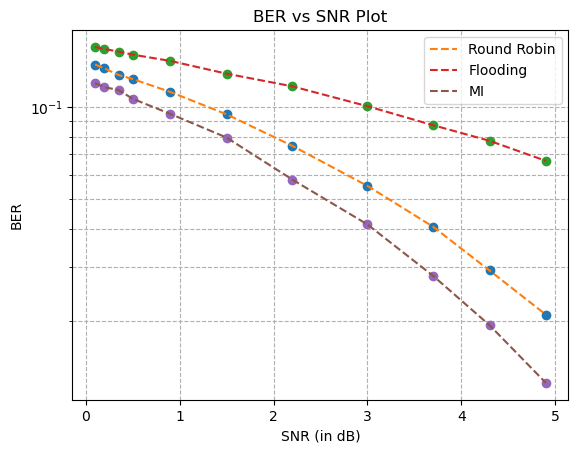

In [22]:
plt.plot(snrdb_vals, bers_round_robin_1, 'o')  
plt.plot(snrdb_vals, bers_round_robin_1, '--',label="Round Robin")
plt.plot(snrdb_vals, bers_flooding_1, 'o')  
plt.plot(snrdb_vals, bers_flooding_1, '--',label="Flooding")
plt.plot(snrdb_vals, bers_MI_1, 'o')  
plt.plot(snrdb_vals, bers_MI_1, '--',label="MI")



plt.title("BER vs SNR Plot")
plt.ylabel("BER")
plt.xlabel("SNR (in dB)")
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()


### Finding number of iterations taken to converge

In [23]:
H = np.array( [[0,0,1,1,0,0,1,0,0,0,0,0,0,0,0]
,[1,0,0,0,1,0,0,1,0,0,0,0,0,0,0]
,[0,1,0,0,0,1,0,0,1,0,0,0,0,0,0]
,[1,0,0,0,0,1,1,0,0,0,0,0,0,0,0]
,[0,1,0,1,0,0,0,1,0,0,0,0,0,0,0]
,[0,0,1,0,1,0,0,0,1,0,0,0,0,0,0]
,[1,0,0,1,0,0,0,0,1,0,0,0,0,0,0]
,[0,1,0,0,1,0,1,0,0,0,0,0,0,0,0]
,[0,0,1,0,0,1,0,1,0,0,0,0,0,0,0]
,[1,0,0,1,0,0,1,0,0,1,0,0,1,0,0]
,[0,1,0,0,1,0,0,1,0,0,1,0,0,1,0]
,[0,0,1,0,0,1,0,0,1,0,0,1,0,0,1]],dtype=int)
n = H.shape[1]
binary_vectors = [np.array(v) for v in itertools.product([0, 1], repeat=n)]
C = []
for c in binary_vectors:
    if np.sum(np.dot(H,c.T)%2)==0:
        C.append(c)


# print("H : \n",H)
C = get_codewords(H)
# print("Codewords : \n",C)
# print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
# print("dmin = ",dmin)




In [24]:
def get_avg_iters(H,C,N,snrdb,q,max_iter,scheduling):
    snr = math.pow(10,snrdb/20)
    sigma = 1/math.sqrt(snr)
    avg_i = 0

    for i in range(N):
        dec = Decoder(H,None,None,max_iter,q)
        c = C[np.random.choice(len(C))]
        y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)
        c_hat = dec.decode(y,scheduling=scheduling)
        c_hat = [1 if val else 0 for val in c_hat]
        c_hat = np.array(c_hat)%2
        e = np.sum((c_hat+c)%2)/len(c)
        i = dec.iteration_number
        avg_i = avg_i + i

    avg_i = avg_i/N
    return avg_i

    

In [25]:
N = 200 # number of simulations
snrdb = 2 # snr in dB
q = 3 # cluster size
max_iter = 1000 # max number of iterations for the decoder


avg_i_rr2 = get_avg_iters(H,C,N,snrdb,2,max_iter,"round-robin")
avg_i_rr3 = get_avg_iters(H,C,N,snrdb,3,max_iter,"round-robin")
avg_i_rr4 = get_avg_iters(H,C,N,snrdb,4,max_iter,"round-robin")
avg_i_rr6 = get_avg_iters(H,C,N,snrdb,6,max_iter,"round-robin")
avg_i_fl = get_avg_iters(H,C,N,snrdb,H.shape[0],max_iter,"round-robin")
avg_i_mi2 = get_avg_iters(H,C,N,snrdb,2,max_iter,"mi")
avg_i_mi3 = get_avg_iters(H,C,N,snrdb,3,max_iter,"mi")
avg_i_mi4 = get_avg_iters(H,C,N,snrdb,4,max_iter,"mi")
avg_i_mi6 = get_avg_iters(H,C,N,snrdb,6,max_iter,"mi")


print(f"Average Number of iterations\n-------------------------------")
print("Decoder(size_cluster)\t#iters\n-------------------------------")

print(f"Flooding\t:\t{avg_i_fl}")

print(f"Round Robin(2)\t:\t{avg_i_rr2}")
print(f"Round Robin(3)\t:\t{avg_i_rr3}")
print(f"Round Robin(4)\t:\t{avg_i_rr4}")
print(f"Round Robin(6)\t:\t{avg_i_rr6}")

print(f"Mutual Info.(2)\t:\t{avg_i_mi2}")
print(f"Mutual Info.(3)\t:\t{avg_i_mi3}")
print(f"Mutual Info.(4)\t:\t{avg_i_mi4}")
print(f"Mutual Info.(6)\t:\t{avg_i_mi6}")




NameError: name 'Dec' is not defined